# Titanic: Modelos para classificação

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
sns.set(style="darkgrid")

## Carregando os dados

A biblioteca Pandas fornece as principais ferramentas para leitura e manipilação dos dados.  
Com ela podemos trabalhar com diferentes tipos e formatos de arquivos, sejam eles __.txt__, __.csv__, __.json__, __parquet__, etc.  
Utilizando a função **.read_csv()** extraimos as informações dos passageiros de um arquivo __.csv__ e armazemos em um dataframe.  
Os dataframes são estruturas de dados bidemensionais, com linhas e colunas, semelhantes as tabelas SQL ou planilhas Excel.

In [3]:
# Leitura dos arquivos .csv para treino e submissão do modelo
train_data_raw = pd.read_csv("./data/train.csv")
submission_data_raw = pd.read_csv("./data/test.csv")

In [4]:
# Apresentando o cabeçalho (5 primeiras linhas) do dataframe 
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Tratando os valores ausentes

Após a leitura dos dados, observamos que existem valores ausentes nosso conjuntos de dados.  
Logo no cabeçalho identificamos que a coluna __Cabin__ possui valores nulos nas linhas 0, 2 e 4.  
Antes de criarmos nosso classificador temos que tratar essas falhas em nossos dados.

In [5]:
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


A função **.display_missing_values()** contabiliza os valores ausentes em todo conjunto de dados.  
Com isso observamos que:
* O conjunto de treinamento possui valores ausentes nas colunas: **Age**, **Cabin** e **Embarked** 
* O conjunto de teste possui valores ausentes nas colunas:  **Age**, **Fare** e **Cabin**

In [6]:
def display_missing_values(data):  
    """Contabiliza os valores ausentes no dataFrame recebido como parâmetro"""
    for column in data.columns:          
        print(f"{column.capitalize()} - Missing values: {data[column].isnull().sum()}")

In [7]:
# Valores ausentes no conjunto de treino
display_missing_values(train_data_raw)

Passengerid - Missing values: 0
Survived - Missing values: 0
Pclass - Missing values: 0
Name - Missing values: 0
Sex - Missing values: 0
Age - Missing values: 177
Sibsp - Missing values: 0
Parch - Missing values: 0
Ticket - Missing values: 0
Fare - Missing values: 0
Cabin - Missing values: 687
Embarked - Missing values: 2


In [8]:
# Valores ausentes no conjunto de submissão
display_missing_values(submission_data_raw)

Passengerid - Missing values: 0
Pclass - Missing values: 0
Name - Missing values: 0
Sex - Missing values: 0
Age - Missing values: 86
Sibsp - Missing values: 0
Parch - Missing values: 0
Ticket - Missing values: 0
Fare - Missing values: 1
Cabin - Missing values: 327
Embarked - Missing values: 0


Existem diferentes abordagens para lidar com os valores ausentes.  
O método mais rápido e radical consiste em remover todas as linhas que possuam valores ausentes.  
No entanto essa abordagem reduziria o número de dados, ou seja passageiros disponíveis, para o treinamento e teste do modelo.  
Uma alternativa menos drástica seria preencher os valores ausentes com um número qualquer.  
No entanto abordagem pode gerar ruídos e distorções ao nosso conjunto de dados.  
Portanto, devemos sempre pensar no contexto do problema antes de tratar os valores ausentes e avaliar a melhor abordagem.

###  Coluna Embarked

A Coluna Embarked armazena informações sobre o local de embarque dos passageiros.  
Essa coluna possui apenas 2 valores ausentes, ambos no conjunto de treino.  
Portanto, a distorção causada pela inserção de um valor aleatório é baixa o suficiente para utilizarmos este método, sem comprometer o conjunto de dados.

In [9]:
# Valores ausentes na coluna Embarked
train_data_raw[train_data_raw["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [10]:
# Preenchendo os valores ausentes com um local de embarque aleatório
embarked_values = train_data_raw["Embarked"].dropna().unique()
train_data_raw["Embarked"] = train_data_raw['Embarked'].fillna(embarked_values[random.randint(0, len(embarked_values))])

In [11]:
train_data_raw[train_data_raw["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Coluna Fare

A Coluna Fare armazena o valor da tarifa pago por cada passageiro.  
Existe apenas um passageiro com o valor da tarifa ausente.  
Como a tarifa é um valor tabelado, podemos usar um passageiro semelhante para aferir o valor da tarifa.

In [12]:
# Valores ausentes na coluna Fare
submission_data_raw[submission_data_raw["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [44]:
# Tarifa para um passageiro da 3° Classe sem acompanhantes
fare = submission_data_raw.groupby(["Pclass", "SibSp",  "Parch"]).Fare.median()[3][0][0]
print(f"Tarifa:{fare}")

Tarifa:7.7958


In [14]:
# Preenchendo os valores ausentes
submission_data_raw["Fare"] = submission_data_raw["Fare"].fillna(fare)

In [15]:
submission_data_raw[submission_data_raw["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Coluna Age

A coluna Age armazena a idade de cada passageiro.  
Podemos usar a mediana ou a média de idade de todos os passageiros para preencher os valores ausentes.

In [16]:
# Valores ausentes na coluna Age
train_data_raw[train_data_raw["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


No entanto, se observarmos no histograma a seguir, é possível notar que a média e mediana varia conforme a idade e classe do passageiro.  
Portanto, a melhor opção seria inserir a mediana da idade para cada sexo por classe de passageiro.

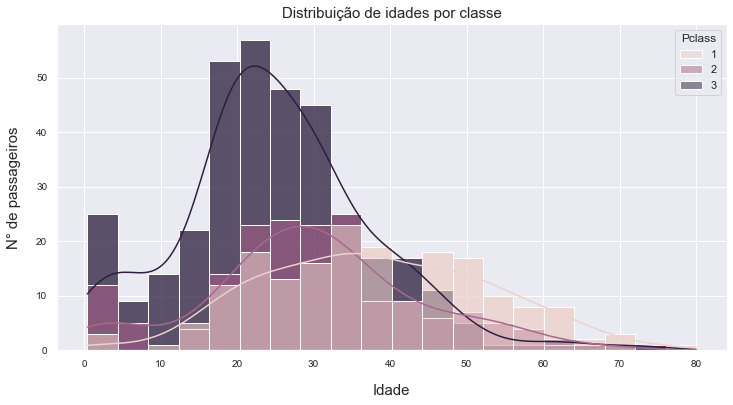

In [18]:
# Distribuição de idades por classe
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data_raw, x="Age", hue="Pclass")
sns.histplot(data=train_data_raw, kde=True, x="Age", hue="Pclass")

plt.xlabel("Idade", size=15, labelpad=15)
plt.ylabel("N° de passageiros", size=15, labelpad=15)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=10)

plt.title("Distribuição de idades por classe", size=15, y=1.0)
plt.show()

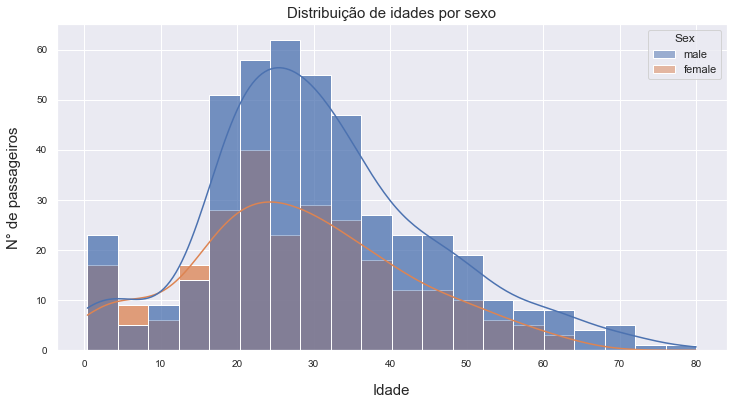

In [19]:
# Distribuição de idades por sexo
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data_raw, x="Age", hue="Sex")
sns.histplot(data=train_data_raw, kde=True, x="Age", hue="Sex")

plt.xlabel("Idade", size=15, labelpad=15)
plt.ylabel("N° de passageiros", size=15, labelpad=15)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=10)

plt.title("Distribuição de idades por sexo", size=15, y=1.0)
plt.show()

In [20]:
# Agrupando os dados por sexo, classe e idade
age_by_pclass_and_sex = train_data_raw.groupby(["Sex", "Pclass"]).median()['Age']

for pclass in range(1, 4):
    for sex in ["female", "male"]:
        print(f"Classe: {pclass} \tSexo: {sex.capitalize()} \tMediana de Idade: {age_by_pclass_and_sex[sex][pclass]}")

Classe: 1 	Sexo: Female 	Mediana de Idade: 35.0
Classe: 1 	Sexo: Male 	Mediana de Idade: 40.0
Classe: 2 	Sexo: Female 	Mediana de Idade: 28.0
Classe: 2 	Sexo: Male 	Mediana de Idade: 30.0
Classe: 3 	Sexo: Female 	Mediana de Idade: 21.5
Classe: 3 	Sexo: Male 	Mediana de Idade: 25.0


In [21]:
# Preenchendo os valores ausentes na coluna Age
train_data_raw["Age"] = train_data_raw.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))
submission_data_raw["Age"] = submission_data_raw.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))

In [22]:
train_data_raw[train_data_raw["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Coluna Cabin

A coluna Cabin é um dado delicado, pois uma parte significativa dos dados foi perdida.  
Além disso, as cabines são os decks em que os quartos estão localizados, e esses quartos eram separados principalmente por classe.  
Portanto, podemos remover a coluna Cabin, já que ela está fortemente relacionada a classe dos passageiros.

In [23]:
# Valores ausentes na coluna Cabin
train_data_raw[train_data_raw["Cabin"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,NaN,S


In [24]:
# Removendo a coluna Cabin
train_data_raw = train_data_raw.drop("Cabin", axis=1)
submission_data_raw = submission_data_raw.drop("Cabin", axis=1)

Após a limpeza dos conjuntos, não encontramos mais valores ausentes. Agora podemos começar a explorar o nosso conjunto de dados.

In [25]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


## Selecionando _features_

Com o conjunto devidamente tratado, podemos começar a selecionar as melhores _features_ do modelo.

In [26]:
train_data = train_data_raw
submission_data = submission_data_raw

Antes de selecionar nossas features, precisamos entender e classificar os nossos dados em difentes tipos.  

As colunas Pclass, Sex e Embarked armazenam dados **categóricos** .  
São os dados representam categorias, podendo assumir apenas um conjunto de valores predeterminado. 

Já a coluna Survived armazena dados do tipo **binário** .  
Eles são um caso especial dos dados categóricos, quando existem apenas duas categorias, como 0 e 1 ou verdadeiro e falso.

As colunas Age, SibSp, Parch e Fare armazenam dados **numéricos** .  
Podemos ainda diferenciar mais os dados numéricos.  
A coluna Fare armazena dados numéricos **contínuos**, ou seja dados que podem assumir qualquer valor em um intervalo.  
Enquanto as colunas Age, SibSp e Parch armazenam dados numéricos **discretos**, ou seja dados que podem assumir apenas valores inteiros.


In [27]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


Precisamos tratar alguns tipos de dados para que os modelos possam aprender com os eles.  
Para os dados categóricos, podemos utilizar o OneHotEncoder para converter cada valor de categoria em uma nova coluna e atribuído um valor 1 ou 0 a coluna.

In [28]:
def encode_feature(data):
    categorical_features = ["Pclass", "Sex", "Embarked"]
    encoded_features = []

    for feature in categorical_features:
        encoded_feature = OneHotEncoder().fit_transform(data[feature].values.reshape(-1, 1)).toarray()
        n = data[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feature, columns=cols)
        encoded_df.index = data.index
        encoded_features.append(encoded_df)
    return encoded_features

In [29]:
encoded_features = encode_feature(train_data)
train_data = pd.concat([train_data, *encoded_features[:6]], axis=1)

In [30]:
encoded_features = encode_feature(submission_data)
submission_data = pd.concat([submission_data, *encoded_features[:6]], axis=1)

In [31]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Por fim, removemos as colunas PassengerId, Name, Sex, Ticket e Embarked.

In [32]:
drop_cols = ["PassengerId", "Name", "Sex", "Ticket", "Embarked"]
train_data.drop(columns=drop_cols, inplace=True)
submission_data.drop(columns=drop_cols, inplace=True)

In [33]:
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
0,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Criando um modelo

In [34]:
X = StandardScaler().fit_transform(train_data.drop("Survived", axis=1))
Y = train_data["Survived"].values
X_submission = StandardScaler().fit_transform(submission_data)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

In [36]:
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=0)
decision_tree_model.fit(X_train, Y_train)
accuracy_score(Y_test, decision_tree_model.predict(X_test))

0.8022388059701493

In [37]:
random_forest_model = RandomForestClassifier(max_depth=5, random_state=0)
random_forest_model.fit(X_train, Y_train)
accuracy_score(Y_test, random_forest_model.predict(X_test))

0.8283582089552238

### Ajustando parametros do modelo

In [38]:
def change_max_depth(model_label, max_depth):
    for depth in range(2, max_depth+1):
        model = DecisionTreeClassifier(max_depth=depth, random_state=0) if model_label == "DecisionTree" else RandomForestClassifier(max_depth=depth, random_state=0)
        model.fit(X_train, Y_train)
        accuracy = accuracy_score(Y_test, model.predict(X_test))
        print(f"Modelo: {model_label} \tPronfunidade: {depth} \tAcurácia:{round(accuracy*100)} %")

In [39]:
change_max_depth("DecisionTree", 10)

Modelo: DecisionTree 	Pronfunidade: 2 	Acurácia:76 %
Modelo: DecisionTree 	Pronfunidade: 3 	Acurácia:82 %
Modelo: DecisionTree 	Pronfunidade: 4 	Acurácia:82 %
Modelo: DecisionTree 	Pronfunidade: 5 	Acurácia:80 %
Modelo: DecisionTree 	Pronfunidade: 6 	Acurácia:78 %
Modelo: DecisionTree 	Pronfunidade: 7 	Acurácia:79 %
Modelo: DecisionTree 	Pronfunidade: 8 	Acurácia:77 %
Modelo: DecisionTree 	Pronfunidade: 9 	Acurácia:78 %
Modelo: DecisionTree 	Pronfunidade: 10 	Acurácia:75 %


In [40]:
change_max_depth("RandomForest", 10)

Modelo: RandomForest 	Pronfunidade: 2 	Acurácia:75 %
Modelo: RandomForest 	Pronfunidade: 3 	Acurácia:79 %
Modelo: RandomForest 	Pronfunidade: 4 	Acurácia:83 %
Modelo: RandomForest 	Pronfunidade: 5 	Acurácia:83 %
Modelo: RandomForest 	Pronfunidade: 6 	Acurácia:83 %
Modelo: RandomForest 	Pronfunidade: 7 	Acurácia:83 %
Modelo: RandomForest 	Pronfunidade: 8 	Acurácia:82 %
Modelo: RandomForest 	Pronfunidade: 9 	Acurácia:82 %
Modelo: RandomForest 	Pronfunidade: 10 	Acurácia:82 %
